In [ ]:
pip install sktime

# **Required Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import time, itertools
import tensorflow as tf
import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
import os, math
from tensorflow.keras.models import load_model
import os, json
from tensorflow.keras import models


# **Loading Datasets**

In [ ]:
# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("CinCECGTorso_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("CinCECGTorso_TEST.ts")


In [ ]:
print(X_train.shape)
print(X_train.head())
print(y_train)

(40, 1)
                                               dim_0
0  0      -1.100932
1      -1.136304
2      -0.26...
1  0       0.277956
1       0.293748
2       0.32...
2  0      -0.259781
1      -0.257882
2      -0.25...
3  0      -0.100409
1      -0.068534
2      -0.05...
4  0       0.083505
1       0.079466
2       0.07...
['1' '3' '4' '3' '3' '3' '2' '4' '4' '2' '3' '3' '2' '3' '3' '3' '2' '4'
 '1' '4' '3' '4' '2' '2' '2' '2' '4' '4' '2' '3' '4' '3' '2' '1' '2' '4'
 '1' '2' '1' '2']


In [ ]:
print(X_test.shape)
print(X_test.head())
print(y_test)

(1380, 1)
                                               dim_0
0  0       0.394755
1       0.426828
2       0.40...
1  0      -0.250971
1      -0.243591
2      -0.17...
2  0       0.766713
1       0.773346
2       0.76...
3  0      -0.114540
1      -0.126016
2      -0.15...
4  0      -0.291910
1      -0.306565
2      -0.31...
['3' '2' '4' ... '1' '4' '4']


# **Checking for Missing Values**

In [ ]:
#Checking for missing values in the data

print("Total missing values in X_train")
print(X_train.isnull().sum())

y_missing_values= (y_train == '') | (y_train == None)
tot_missing = y_missing_values.sum()

print(f"Total missing labels: {tot_missing}")



Total missing values in X_train
dim_0    0
dtype: int64
Total missing labels: 0


# **Class Distribution visualization**

/tmp/ipython-input-2984266170.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis", order=distinct_labels)


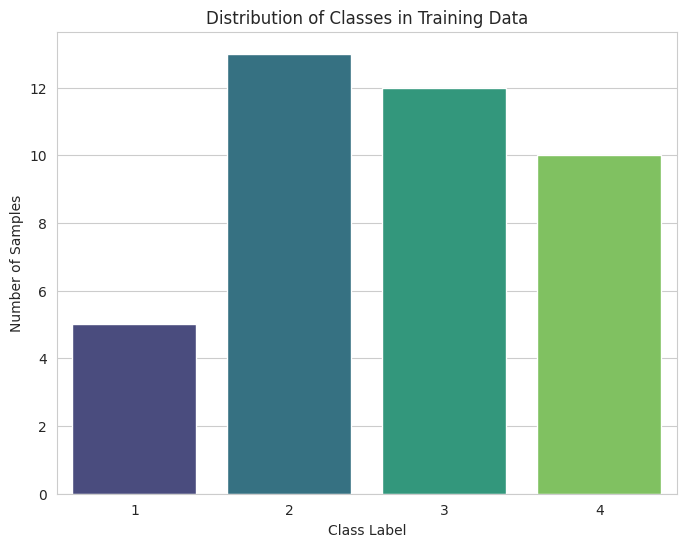

In [ ]:
# Converting DataFrame to a 2D numpy array
X_train_arr = np.array(X_train['dim_0'].tolist())
distinct_labels = np.unique(y_train)

# Setting a style
sns.set_style("whitegrid")

# Bar Chart to check the number of samples in each class
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette="viridis", order=distinct_labels)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# **Plotting samples from each class**

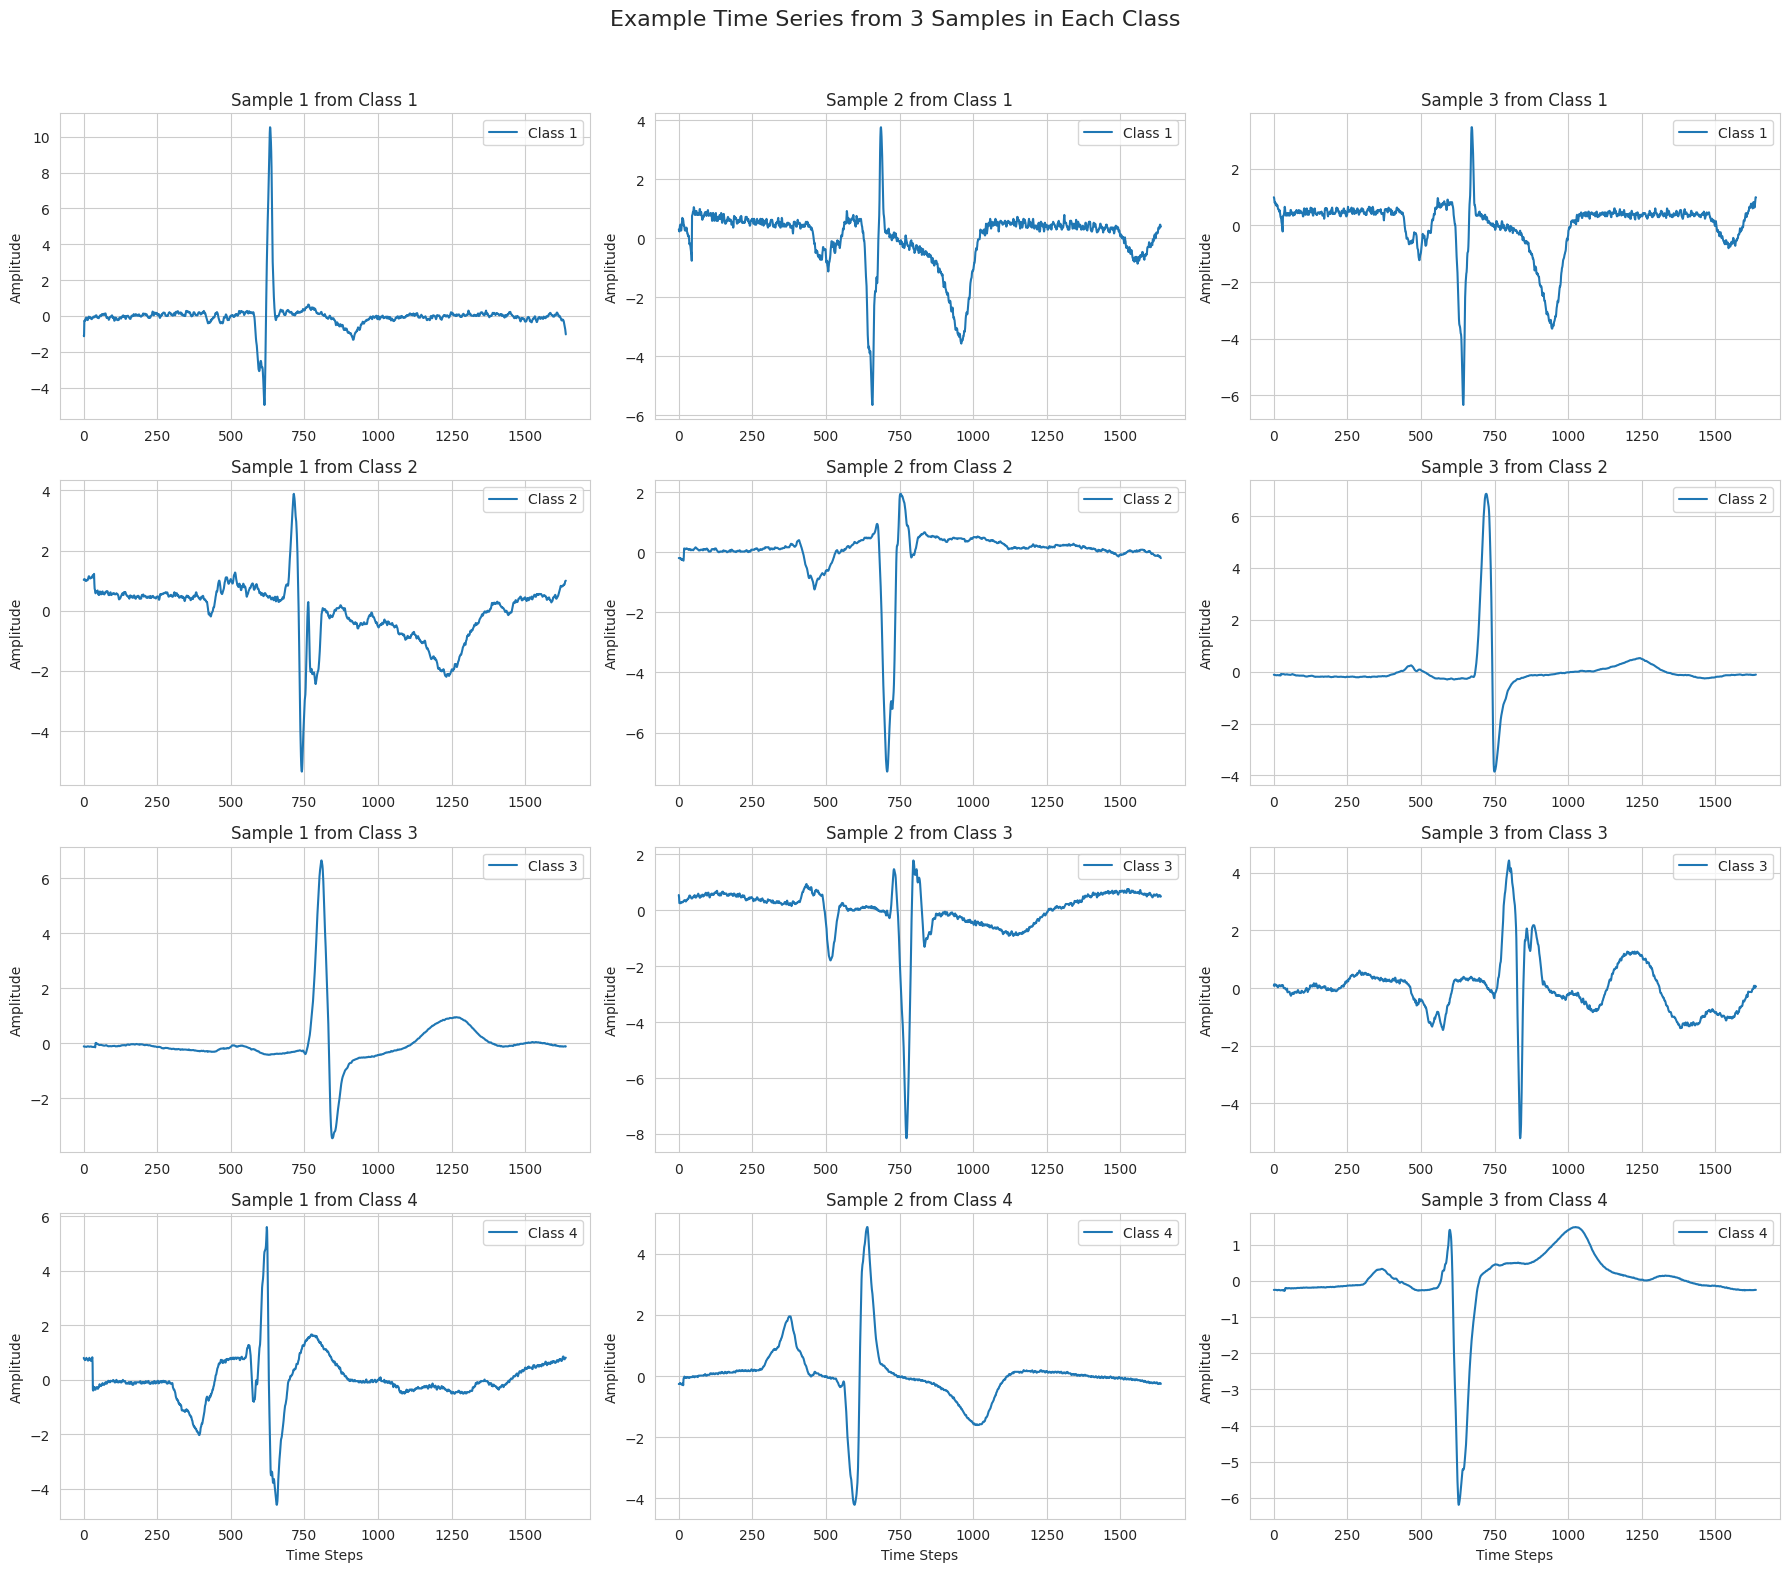

In [ ]:
num_samples = 3
diff_labels = np.unique(y_train)

fig, axes = plt.subplots(len(diff_labels), num_samples, figsize=(18, 4 * len(diff_labels)))
fig.suptitle(f'Example Time Series from {num_samples} Samples in Each Class', fontsize=16)

for i, label in enumerate(diff_labels):
    # Finding all indices for current label
    ind = np.where(y_train == label)[0]

    # To avoid plotting the same samples, shuffle the indices
    np.random.shuffle(ind)
    sample_to_plot = ind[:num_samples]

    for j, idx in enumerate(sample_to_plot):
        time_series_data = X_train_arr[idx]
        axes[i, j].plot(time_series_data, label=f'Class {label}')
        axes[i, j].set_title(f'Sample {j+1} from Class {label}')
        axes[i, j].set_ylabel('Amplitude')
        axes[i, j].legend()

# Set a common xlabel for the bottom row of plots
for j in range(num_samples):
    axes[-1, j].set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# **Average Time Series Plot**

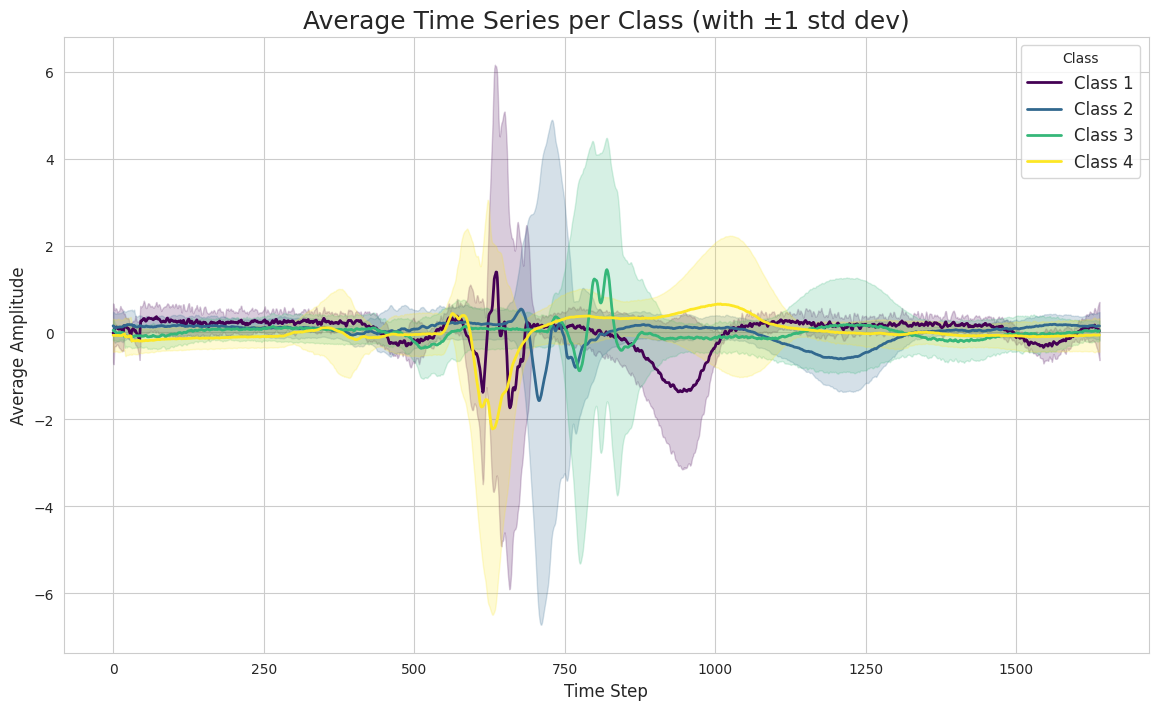

In [ ]:
unique_class_labels = sorted(np.unique(y_train))
int_label = {label: i for i, label in enumerate(unique_class_labels)}
y_train_int = np.array([int_label[y] for y in y_train])

plt.figure(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_class_labels)))

for i, label in enumerate(unique_class_labels):
    # Taking all series belonging to the current class
    class_series = X_train[y_train == label].iloc[:, 0]

    # Stacking into a 2D numpy array to cal mean and std
    stacked_series = np.stack(class_series.values)

    mean_series = np.mean(stacked_series, axis=0)
    std_series = np.std(stacked_series, axis=0)

    # Plotting mean series
    plt.plot(mean_series, label=f'Class {label}', color=colors[i], linewidth=2)

    # Plotting standard deviation
    plt.fill_between(range(len(mean_series)), mean_series - std_series, mean_series + std_series,
                     color=colors[i], alpha=0.2)

plt.title('Average Time Series per Class (with ±1 std dev)', fontsize=18)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Amplitude', fontsize=12)
plt.legend(title='Class', fontsize=12)
plt.show()

# **Visualizing Statistical Features**

Converting feature columns to numeric


/tmp/ipython-input-2608628725.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], data=df, x='class', y='mean_val', palette='viridis')
/tmp/ipython-input-2608628725.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], data=df, x='class', y='std_dev', palette='viridis')
/tmp/ipython-input-2608628725.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=df, x='class', y='min_val', palette='viridis')
/tmp/ipython-input-2608628725.py:47: FutureWarning: 

Passing `palette` without assigning `hue` 

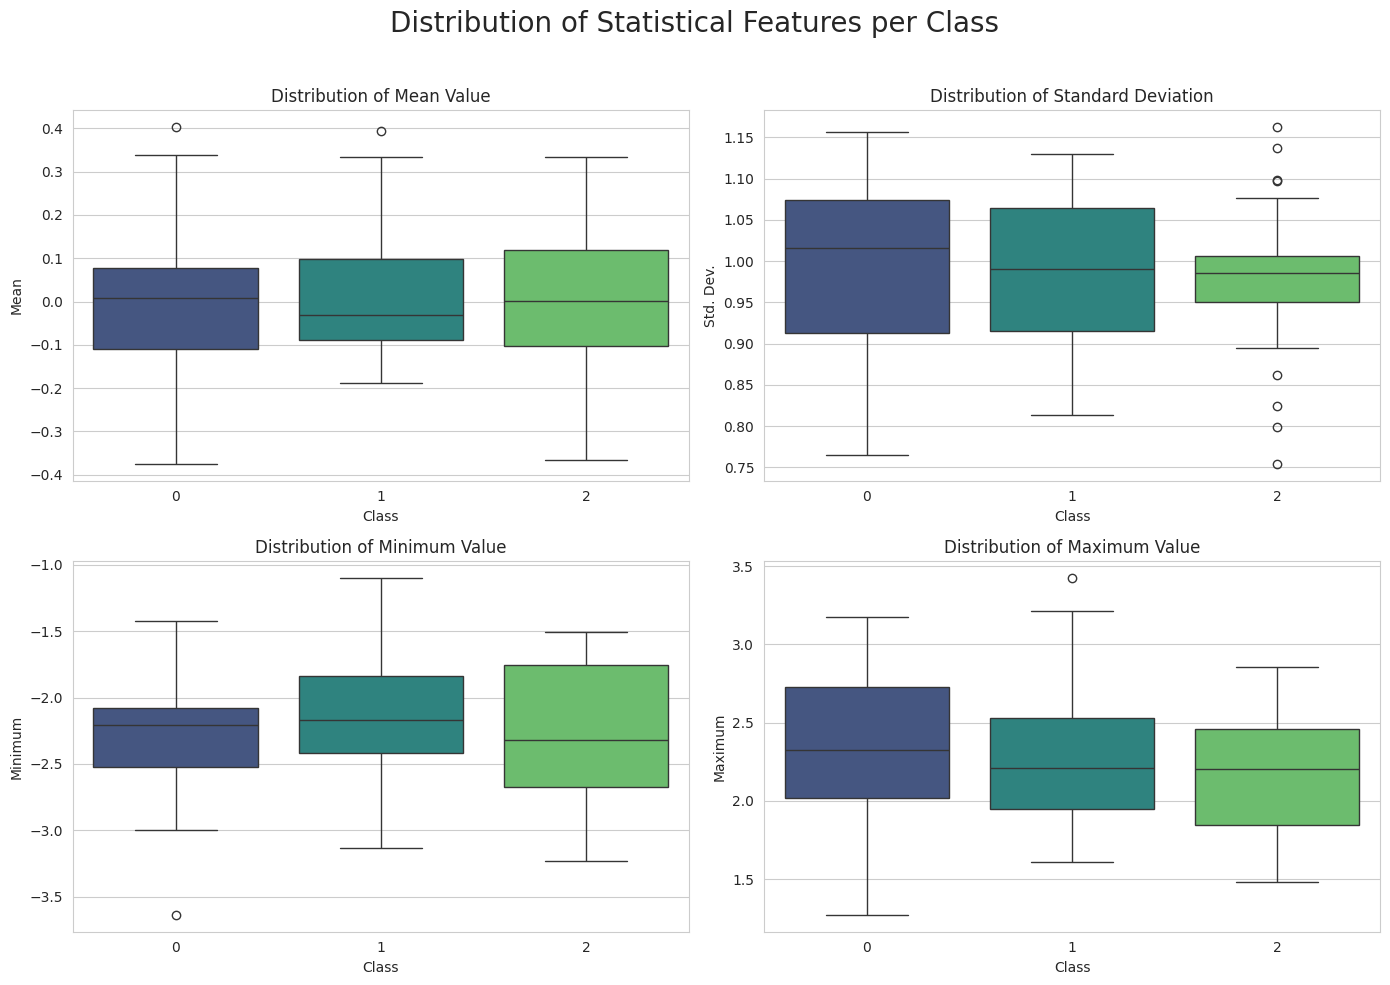

In [ ]:
num_samples = 100
num_features = 50
X_train_rand = np.random.randn(num_samples, num_features)
X_train_str = X_train_rand.astype(str)
y_train_rand = np.random.randint(0, 3, num_samples)


df = pd.DataFrame(X_train_str)

# Storing original time series columns
feature_cols = df.columns.tolist()


print("Converting feature columns to numeric")
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)

df['class'] = y_train_rand

#Calculating statistics for each time series
df['mean_val'] = df[feature_cols].mean(axis=1)
df['std_dev']  = df[feature_cols].std(axis=1)
df['min_val']  = df[feature_cols].min(axis=1)
df['max_val']  = df[feature_cols].max(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Statistical Features per Class', fontsize=20)

sns.boxplot(ax=axes[0, 0], data=df, x='class', y='mean_val', palette='viridis')
axes[0, 0].set_title('Distribution of Mean Value')
axes[0, 0].set_xlabel('Class')
axes[0, 0].set_ylabel('Mean')


sns.boxplot(ax=axes[0, 1], data=df, x='class', y='std_dev', palette='viridis')
axes[0, 1].set_title('Distribution of Standard Deviation')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Std. Dev.')

sns.boxplot(ax=axes[1, 0], data=df, x='class', y='min_val', palette='viridis')
axes[1, 0].set_title('Distribution of Minimum Value')
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Minimum')

sns.boxplot(ax=axes[1, 1], data=df, x='class', y='max_val', palette='viridis')
axes[1, 1].set_title('Distribution of Maximum Value')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Maximum')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
print(y_test)
print(y_test.shape)

['3' '2' '4' ... '1' '4' '4']
(1380,)


# **1D CNN Model**

Class weights: {0: 2.0, 1: 0.7692307692307693, 2: 0.8333333333333334, 3: 1.0}

 Run 1 — Epochs: 100, LR: 0.1, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2500 | Precision: 0.0626 | Recall: 0.2500 | F1 (weighted): 0.1001
 New best model (by weighted F1) saved: saved_models/best_model_ecgtorso_f1.keras

 Run 2 — Epochs: 100, LR: 0.1, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2500 | Precision: 0.0625 | Recall: 0.2500 | F1 (weighted): 0.1000

 Run 3 — Epochs: 100, LR: 0.1, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8181 | Precision: 0.8400 | Recall: 0.8181 | F1 (weighted): 0.8091
 New best model (by weighted F1) saved: saved_models/best_model_ecgtorso_f1.keras

 Run 4 — Epochs: 100, LR: 0.01, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.7935 | Precision: 0.8165 | Recall: 0.7935 | F1 (weighted): 0.7827

 Run 5 — Epochs: 100, LR: 0.01, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.7978 | Precision: 0.8564 | Recall: 0.7978 | F1 (weighted): 0.7740

 Run 6 — Epochs: 100, LR: 0.01, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8232 | Precision: 0.8334 | Recall: 0.8232 | F1 (weighted): 0.8121
 New best model (by weighted F1) saved: saved_models/best_model_ecgtorso_f1.keras

 Run 7 — Epochs: 100, LR: 0.001, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8362 | Precision: 0.8583 | Recall: 0.8362 | F1 (weighted): 0.8309
 New best model (by weighted F1) saved: saved_models/best_model_ecgtorso_f1.keras

 Run 8 — Epochs: 100, LR: 0.001, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8152 | Precision: 0.8523 | Recall: 0.8152 | F1 (weighted): 0.7987

 Run 9 — Epochs: 100, LR: 0.001, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8275 | Precision: 0.8432 | Recall: 0.8275 | F1 (weighted): 0.8156

 Run 10 — Epochs: 500, LR: 0.1, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2486 | Precision: 0.0618 | Recall: 0.2486 | F1 (weighted): 0.0990

 Run 11 — Epochs: 500, LR: 0.1, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2536 | Precision: 0.0643 | Recall: 0.2536 | F1 (weighted): 0.1026

 Run 12 — Epochs: 500, LR: 0.1, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.3638 | Precision: 0.3473 | Recall: 0.3638 | F1 (weighted): 0.2918

 Run 13 — Epochs: 500, LR: 0.01, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.7920 | Precision: 0.8565 | Recall: 0.7920 | F1 (weighted): 0.7729

 Run 14 — Epochs: 500, LR: 0.01, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.7565 | Precision: 0.8412 | Recall: 0.7565 | F1 (weighted): 0.7026

 Run 15 — Epochs: 500, LR: 0.01, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.7645 | Precision: 0.8011 | Recall: 0.7645 | F1 (weighted): 0.7503

 Run 16 — Epochs: 500, LR: 0.001, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8145 | Precision: 0.8405 | Recall: 0.8145 | F1 (weighted): 0.8014

 Run 17 — Epochs: 500, LR: 0.001, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8152 | Precision: 0.8503 | Recall: 0.8152 | F1 (weighted): 0.8024

 Run 18 — Epochs: 500, LR: 0.001, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8174 | Precision: 0.8504 | Recall: 0.8174 | F1 (weighted): 0.8018

 Run 19 — Epochs: 1000, LR: 0.1, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2478 | Precision: 0.0614 | Recall: 0.2478 | F1 (weighted): 0.0984

 Run 20 — Epochs: 1000, LR: 0.1, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2486 | Precision: 0.0618 | Recall: 0.2486 | F1 (weighted): 0.0990

 Run 21 — Epochs: 1000, LR: 0.1, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.2123 | Precision: 0.2372 | Recall: 0.2123 | F1 (weighted): 0.1915

 Run 22 — Epochs: 1000, LR: 0.01, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.5993 | Precision: 0.8267 | Recall: 0.5993 | F1 (weighted): 0.5385

 Run 23 — Epochs: 1000, LR: 0.01, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.6870 | Precision: 0.7298 | Recall: 0.6870 | F1 (weighted): 0.6571

 Run 24 — Epochs: 1000, LR: 0.01, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8819 | Precision: 0.8856 | Recall: 0.8819 | F1 (weighted): 0.8782
 New best model (by weighted F1) saved: saved_models/best_model_ecgtorso_f1.keras

 Run 25 — Epochs: 1000, LR: 0.001, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8290 | Precision: 0.8446 | Recall: 0.8290 | F1 (weighted): 0.8202

 Run 26 — Epochs: 1000, LR: 0.001, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8261 | Precision: 0.8388 | Recall: 0.8261 | F1 (weighted): 0.8193

 Run 27 — Epochs: 1000, LR: 0.001, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Results — Acc: 0.8239 | Precision: 0.8424 | Recall: 0.8239 | F1 (weighted): 0.8103

 All Runs Summary:
    Run  Epochs  Learning Rate  Batch Size  Test Accuracy  Precision_w  \
0    24    1000          0.010          32         0.8819       0.8856   
1     7     100          0.001           8         0.8362       0.8583   
2    25    1000          0.001           8         0.8290       0.8446   
3    26    1000          0.001          16         0.8261       0.8388   
4     9     100          0.001          32         0.8275       0.8432   
5     6     100          0.010          32         0.8232       0.8334   
6    27    1000          0.001          32         0.8239       0.8424   
7     3     100          0.100          32         0.8181       0.8400   
8    17     500          0.001          16         0.8152       0.8503   
9    18     500          0.001          32         0.8174       0.8504   
10   16     500          0.001           8         0.8145       0.8405   
11    8 

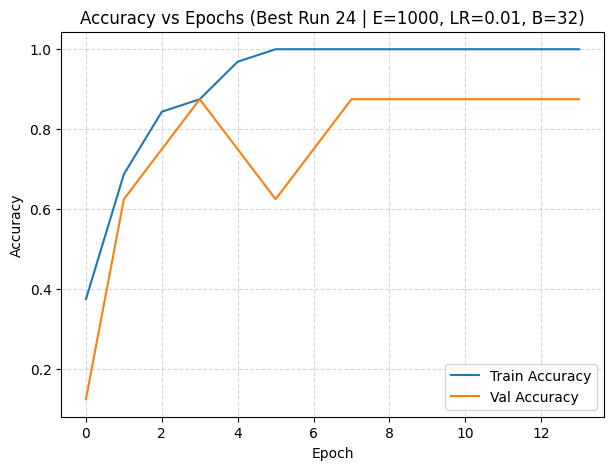

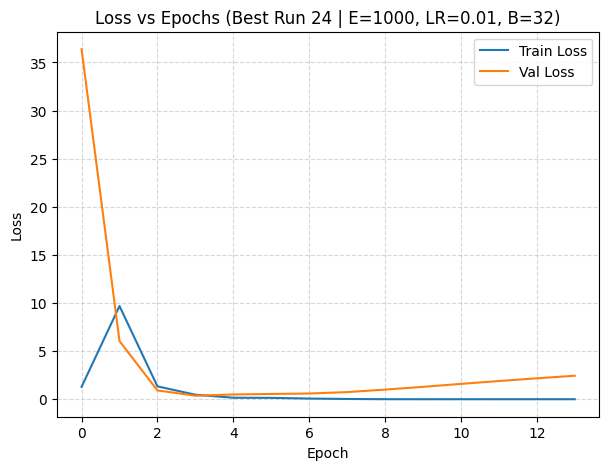

In [ ]:
# Function for plotting accuracy/loss curve
def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy'); h_val_acc = h.get('val_accuracy')
    h_loss = h.get('loss'); h_val_loss = h.get('val_loss')

    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Accuracy'); plt.plot(h_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()


# Calculating per sample z-score
def z_score_per_sample(X):
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    std = np.where(std == 0, 1.0, std)
    return (X - mean) / std


# Converting dataframe to 3D arrays
def dataframe_to_3d_array(X):
    if isinstance(X, pd.DataFrame):
        series_list = X.iloc[:, 0].tolist()
    elif isinstance(X, np.ndarray):
        series_list = X[:, 0].tolist()
    else:
        raise TypeError("X must be a DataFrame or NumPy array")
    return np.array([np.array(s) for s in series_list])

X_train_np = dataframe_to_3d_array(X_train)[..., np.newaxis]
X_test_np = dataframe_to_3d_array(X_test)[..., np.newaxis]

X_train_np = z_score_per_sample(X_train_np)
X_test_np  = z_score_per_sample(X_test_np)


# Encoding labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

#Adding class weights to handle imbalanced data
classes = np.unique(y_train_enc)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weight)


# List for Grid Search for Hyperparameter Tuning
epochs_list = [100, 500, 1000]
lr_list = [0.1, 0.01, 0.001]
batch_size_list = [8, 16, 32]

# Results tracking
results = []
best_cnn_ecgt_f1 = -np.inf
best_cnn_ecgt_model = None
best_cnn_ecgt_model_info = {}
best_cnn_ecgt_history = None

# Output directory
os.makedirs("saved_models", exist_ok=True)

run = 0
for epochs in epochs_list:
    for lr in lr_list:
        for bs in batch_size_list:
            run += 1
            print(f"\n Run {run} — Epochs: {epochs}, LR: {lr}, Batch Size: {bs}")

            # Building the model
            model = Sequential([
                Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_np.shape[1], 1)),
                MaxPooling1D(pool_size=2),
                Dropout(0.3),
                Conv1D(filters=128, kernel_size=3, activation='relu'),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(100, activation='relu'),
                Dropout(0.2),
                Dense(y_train_cat.shape[1], activation='softmax')
            ])

            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            # Training the model
            history = model.fit(
                X_train_np, y_train_cat,
                epochs=epochs,
                batch_size=bs,
                validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                verbose=0,
                class_weight=class_weight
            )

            # Evaluating the model
            test_loss, test_acc = model.evaluate(X_test_np, y_test_cat, verbose=0)

            y_prob = model.predict(X_test_np, verbose=0)
            y_pred = y_prob.argmax(axis=1)
            y_true = y_test_enc

            # Weighted metrics for imbalance
            cnn_acc  = accuracy_score(y_true, y_pred)
            cnn_prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            cnn_rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            cnn_f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            print(f" Results — Acc: {cnn_acc:.4f} | Precision: {cnn_prec:.4f} | Recall: {cnn_rec:.4f} | F1 (weighted): {cnn_f1:.4f}")

            # Log result
            results.append({
                "Run": run,
                "Epochs": epochs,
                "Learning Rate": lr,
                "Batch Size": bs,
                "Test Accuracy": round(float(cnn_acc), 4),
                "Precision_w": round(float(cnn_prec), 4),
                "Recall_w": round(float(cnn_rec), 4),
                "F1_w": round(float(cnn_f1), 4),
            })

            # Saving best model by weighted F1
            if cnn_f1 > best_cnn_ecgt_f1:
                best_cnn_ecgt_f1 = cnn_f1
                best_cnn_ecgt_model = model
                best_cnn_ecgt_history = history
                best_cnn_ecgt_model_info = {
                    "Run": run,
                    "Epochs": epochs,
                    "Learning Rate": lr,
                    "Batch Size": bs,
                    "Test Accuracy": round(float(cnn_acc), 4),
                    "Precision_w": round(float(cnn_prec), 4),
                    "Recall_w": round(float(cnn_rec), 4),
                    "F1_w": round(float(cnn_f1), 4),
                }
                cnn_ecgt_model_path = "saved_models/best_model_ecgtorso_f1.keras"
                model.save(cnn_ecgt_model_path)
                print(f" New best model (by weighted F1) saved: {cnn_ecgt_model_path}")

                np.save("y_true_ecgtorso.npy", y_true)
                np.save("y_prob_ecgtorso_cnn.npy", y_prob)

# Final results
results_df = pd.DataFrame(results)
print("\n All Runs Summary:")
print(results_df.sort_values(by="F1_w", ascending=False).reset_index(drop=True))

print("\n Best Model Configuration (by F1):")
print(best_cnn_ecgt_model_info)

# Plotting accuracy/loss curves for best model
if best_cnn_ecgt_history is not None:
    plot_training_curves_inline(
        best_cnn_ecgt_history,
        title_suffix=(f"(Best Run {best_cnn_ecgt_model_info['Run']} | "
                      f"E={best_cnn_ecgt_model_info['Epochs']}, "
                      f"LR={best_cnn_ecgt_model_info['Learning Rate']}, "
                      f"B={best_cnn_ecgt_model_info['Batch Size']})")
    )


# **Transformer Model**

Class weights: {0: 2.0, 1: 0.8, 2: 0.8, 3: 1.0}
Run 01 | E=100  LR=0.01 B=8  -> Acc=0.2478 | Prec_w=0.0614 | Rec_w=0.2478 | F1_w=0.0984 | time=77.6s
Run 02 | E=100  LR=0.01 B=16 -> Acc=0.2478 | Prec_w=0.0614 | Rec_w=0.2478 | F1_w=0.0984 | time=36.7s
Run 03 | E=100  LR=0.01 B=32 -> Acc=0.2486 | Prec_w=0.0618 | Rec_w=0.2486 | F1_w=0.0990 | time=25.0s
Run 04 | E=100  LR=0.001 B=8  -> Acc=0.8435 | Prec_w=0.8777 | Rec_w=0.8435 | F1_w=0.8291 | time=66.2s
Run 05 | E=100  LR=0.001 B=16 -> Acc=0.2500 | Prec_w=0.1209 | Rec_w=0.2500 | F1_w=0.1607 | time=21.4s
Run 06 | E=100  LR=0.001 B=32 -> Acc=0.8362 | Prec_w=0.8377 | Rec_w=0.8362 | F1_w=0.8340 | time=64.4s
Run 07 | E=100  LR=0.1 B=8  -> Acc=0.2536 | Prec_w=0.0643 | Rec_w=0.2536 | F1_w=0.1026 | time=76.0s
Run 08 | E=100  LR=0.1 B=16 -> Acc=0.2478 | Prec_w=0.0614 | Rec_w=0.2478 | F1_w=0.0984 | time=21.9s
Run 09 | E=100  LR=0.1 B=32 -> Acc=0.2536 | Prec_w=0.0643 | Rec_w=0.2536 | F1_w=0.1026 | time=29.8s
Run 10 | E=500  LR=0.01 B=8  -> Acc=0.2478 

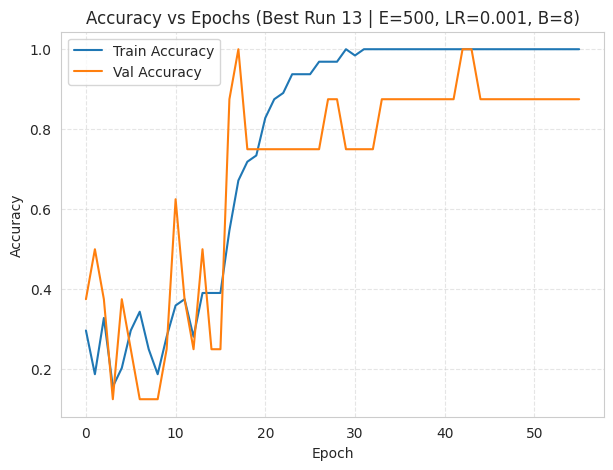

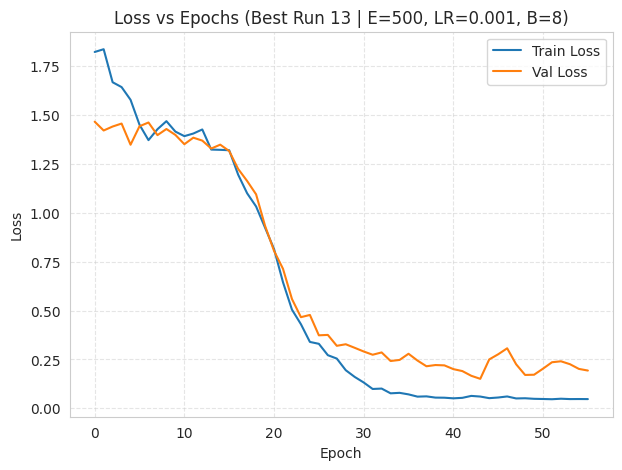

In [ ]:

# Basic Pre-processing functions

def sktime_nested_to_3d(X_nested: pd.DataFrame) -> np.ndarray:
    n_samples, n_channels = X_nested.shape
    seq_len = len(X_nested.iloc[0, 0])
    out = np.empty((n_samples, seq_len, n_channels), dtype=np.float32)
    for i in range(n_samples):
        for c in range(n_channels):
            out[i, :, c] = np.asarray(X_nested.iat[i, c], dtype=np.float32)
    return out

def instance_zscore(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    mean = X.mean(axis=1, keepdims=True)
    std  = X.std(axis=1, keepdims=True)
    return (X - mean) / (std + eps)

#Applying seed for reproducability
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.keras.utils.set_random_seed(seed)

#Function to plot accuracy/loss curves
def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy'); h_val_acc = h.get('val_accuracy')
    h_loss = h.get('loss'); h_val_loss = h.get('val_loss')

    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Accuracy'); plt.plot(h_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

seed_everything(42)

X_train_np = sktime_nested_to_3d(X_train)
X_test_np  = sktime_nested_to_3d(X_test)

X_train_np = instance_zscore(X_train_np)
X_test_np  = instance_zscore(X_test_np)

# One LabelEncoder
le = LabelEncoder()
y_train_idx = le.fit_transform(np.asarray(y_train))
y_test_idx  = le.transform(np.asarray(y_test))
n_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_idx, num_classes=n_classes)
y_test_cat  = to_categorical(y_test_idx,  num_classes=n_classes)

seq_len, n_channels = X_train_np.shape[1], X_train_np.shape[2]

# Sinusoidal Positional Encoding
class SinusoidalPositionalEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]      # (T,1)
        i   = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :] # (1,D)
        angles = pos / tf.pow(10000.0, (2*(tf.floor(i/2))) / tf.cast(self.d_model, tf.float32))
        pe = tf.where(tf.cast(i % 2, tf.bool), tf.cos(angles), tf.sin(angles))  # (T,D)
        return x + pe[tf.newaxis, :, :]

#Building the model
def transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=128, dropout=0.2, l2w=1e-4):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    y = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                      kernel_regularizer=keras.regularizers.l2(l2w))(x)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=x.shape[-1], kernel_size=1,
                      kernel_regularizer=keras.regularizers.l2(l2w))(y)
    y = layers.LayerNormalization(epsilon=1e-6)(y + x)
    return y

def build_ts_transformer(
    seq_len, n_channels, n_classes,
    d_model=64, head_size=32, num_heads=2, ff_dim=128,
    num_transformer_blocks=2, dropout=0.2, l2w=1e-4,
    mlp_units=(128,), mlp_dropout=0.3,
    learning_rate=1e-3
):
    inputs = layers.Input(shape=(seq_len, n_channels))
    x = layers.Conv1D(filters=d_model, kernel_size=1, padding="same",
                      kernel_regularizer=keras.regularizers.l2(l2w))(inputs)
    x = SinusoidalPositionalEncoding(d_model=d_model)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads,
                                ff_dim=ff_dim, dropout=dropout, l2w=l2w)
    # Dual pooling
    x_avg = layers.GlobalAveragePooling1D()(x)
    x_max = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([x_avg, x_max])
    for u in (mlp_units if isinstance(mlp_units, (list, tuple)) else [mlp_units]):
        x = layers.Dense(u, activation="relu", kernel_regularizer=keras.regularizers.l2(l2w))(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

ARCH = dict(
    d_model=64, head_size=32, num_heads=2, ff_dim=128,
    num_transformer_blocks=2, dropout=0.2, l2w=1e-4,
    mlp_units=(128,), mlp_dropout=0.3,
)

# Stratified split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx), = strat_split.split(X_train_np, y_train_idx)
X_tr_base, X_val = X_train_np[train_idx], X_train_np[val_idx]
y_tr_idx_base, y_val_idx = y_train_idx[train_idx], y_train_idx[val_idx]
y_tr_base = to_categorical(y_tr_idx_base, num_classes=n_classes)
y_val     = to_categorical(y_val_idx,     num_classes=n_classes)

# Adding Class weights
classes = np.unique(y_tr_idx_base)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr_idx_base)
class_weight_map = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weight_map)

def augment_timeseries(X, y, jitter_std=0.01, scale_std=0.05, copies=1, rng=123):
    if copies <= 0:
        return X, y
    _rng = np.random.default_rng(rng)
    n, T, C = X.shape
    X_aug = [X]; y_aug = [y]
    for _ in range(copies):
        scale = _rng.normal(loc=1.0, scale=scale_std, size=(n, 1, 1)).astype(np.float32)
        jitter = _rng.normal(loc=0.0, scale=jitter_std, size=(n, T, C)).astype(np.float32)
        X_aug.append(X * scale + jitter)
        y_aug.append(y)
    return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

X_tr, y_tr = augment_timeseries(X_tr_base, y_tr_base, copies=1, rng=123)

# Grid search parameter list
epochs_list = [100, 500, 1000]
lr_list     = [0.01, 0.001, 0.1]
batch_list  = [8, 16, 32]

all_rows = []
best_trans_ecgt_f1 = -1.0
best_trans_ecgt_model = None
best_trans_ecgt_hist = None
best_trans_ecgt_cfg = None

run = 0
for epochs, lr, bs in itertools.product(epochs_list, lr_list, batch_list):
    run += 1
    keras.backend.clear_session()

    model = build_ts_transformer(
        seq_len=seq_len, n_channels=n_channels, n_classes=n_classes,
        learning_rate=lr, **ARCH
    )

    es  = EarlyStopping(monitor="val_loss", patience=12, min_delta=1e-4, restore_best_weights=True, verbose=0)
    rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=0)

    t0 = time.time()
    hist = model.fit(
        X_tr, y_tr,
        epochs=epochs,
        batch_size=bs,
        validation_data=(X_val, y_val),
        callbacks=[es, rlr],
        verbose=0,
        class_weight=class_weight_map
    )
    train_time = time.time() - t0

    # Evaluating the model
    y_prob = model.predict(X_test_np, verbose=0)
    y_pred = y_prob.argmax(axis=1)
    y_true = y_test_idx

    trans_acc  = float(accuracy_score(y_true, y_pred))
    trans_prec = float(precision_score(y_true, y_pred, average='weighted', zero_division=0))
    trans_rec  = float(recall_score(y_true, y_pred, average='weighted', zero_division=0))
    trans_f1   = float(f1_score(y_true, y_pred, average='weighted', zero_division=0))

    print(f"Run {run:02d} | E={epochs:<4} LR={lr:<.4g} B={bs:<2} "
          f"-> Acc={trans_acc:.4f} | Prec_w={trans_prec:.4f} | Rec_w={trans_rec:.4f} | F1_w={trans_f1:.4f} | time={train_time:.1f}s",
          flush=True)

    all_rows.append({
        "Run": run, "Epochs": epochs, "Learning Rate": lr, "Batch Size": bs,
        "Test Accuracy": round(trans_acc, 4), "Precision_w": round(trans_prec, 4),
        "Recall_w": round(trans_rec, 4), "F1_w": round(trans_f1, 4), "_time_sec": round(train_time, 1)
    })

    # Selecting best model by weighted F1
    if trans_f1 > best_trans_ecgt_f1:
        best_trans_ecgt_f1 = trans_f1
        best_trans_ecgt_model = model
        best_trans_ecgt_hist = hist
        best_trans_ecgt_cfg = {
            "Run": run, "Epochs": epochs, "Learning Rate": lr, "Batch Size": bs,
            "Test Accuracy": round(trans_acc, 4), "Precision_w": round(trans_prec, 4),
            "Recall_w": round(trans_rec, 4), "F1_w": round(trans_f1, 4)
        }
        # Saving predicted probabilities
        np.save("y_prob_ecgT_trans.npy", y_prob)


df = pd.DataFrame(all_rows).sort_values("Run")
print("\nAll Run Results (ECGTorso):")
print(df[["Run","Epochs","Learning Rate","Batch Size","Test Accuracy","Precision_w","Recall_w","F1_w","_time_sec"]]
      .to_string(index=False))

print("\nBest Model Configuration (selected by weighted F1):")
print(best_trans_ecgt_cfg)

os.makedirs("saved_models", exist_ok=True)
best_trans_ecgt_path = "saved_models/best_transformer_model_ECGTorso_byF1.keras"
best_trans_ecgt_model.save(best_trans_ecgt_path)
print(f"\nSaved best model to: {best_trans_ecgt_path}")

if best_trans_ecgt_hist is not None:
    plot_training_curves_inline(
        best_trans_ecgt_hist,
        title_suffix=(f"(Best Run {best_trans_ecgt_cfg['Run']} | E={best_trans_ecgt_cfg['Epochs']}, "
                      f"LR={best_trans_ecgt_cfg['Learning Rate']}, B={best_trans_ecgt_cfg['Batch Size']})")
    )


# **Inception Time Model**

Class weights: {np.int64(0): np.float64(2.0), np.int64(1): np.float64(0.8), np.int64(2): np.float64(0.8), np.int64(3): np.float64(1.0)}

 Run 1 — Epochs: 100, LR: 0.1, Batch Size: 8
 Results — Acc: 0.4464 | Precision: 0.6004 | Recall: 0.4464 | F1 (weighted): 0.4490
 Best model and PR data saved.

 Run 2 — Epochs: 100, LR: 0.1, Batch Size: 16
 Results — Acc: 0.5797 | Precision: 0.5877 | Recall: 0.5797 | F1 (weighted): 0.5773
 Best model and PR data saved.

 Run 3 — Epochs: 100, LR: 0.1, Batch Size: 32
 Results — Acc: 0.5471 | Precision: 0.6259 | Recall: 0.5471 | F1 (weighted): 0.5502

 Run 4 — Epochs: 100, LR: 0.01, Batch Size: 8
 Results — Acc: 0.5957 | Precision: 0.6254 | Recall: 0.5957 | F1 (weighted): 0.5860
 Best model and PR data saved.

 Run 5 — Epochs: 100, LR: 0.01, Batch Size: 16
 Results — Acc: 0.3717 | Precision: 0.3038 | Recall: 0.3717 | F1 (weighted): 0.2873

 Run 6 — Epochs: 100, LR: 0.01, Batch Size: 32
 Results — Acc: 0.2732 | Precision: 0.3837 | Recall: 0.2732 | F1 (we

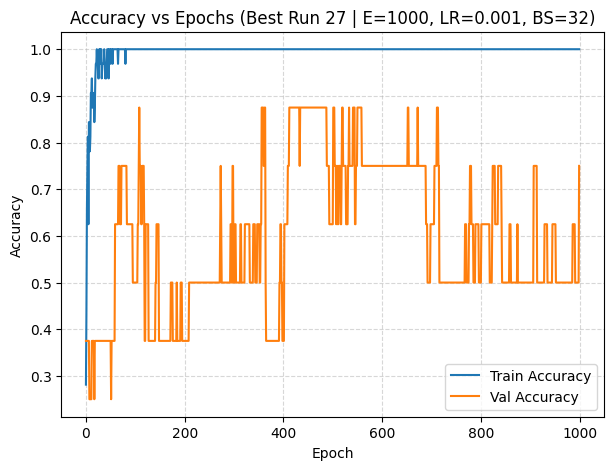

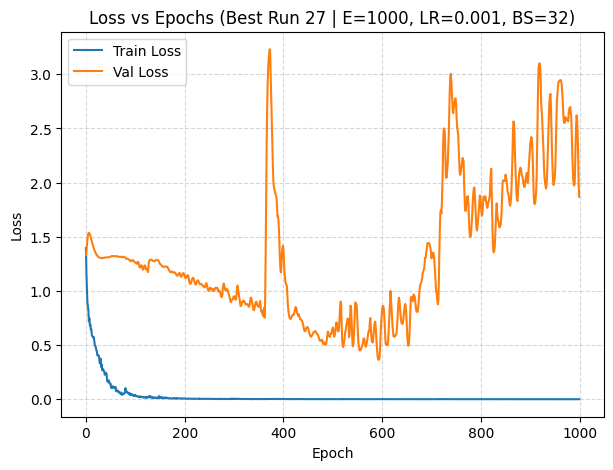

In [ ]:

# Basic Pre-processing of Dataset
def sktime_nested_to_3d(X_nested: pd.DataFrame) -> np.ndarray:
    n_samples, n_channels = X_nested.shape
    seq_len = len(X_nested.iloc[0, 0])
    out = np.empty((n_samples, seq_len, n_channels), dtype=np.float32)
    for i in range(n_samples):
        for c in range(n_channels):
            out[i, :, c] = np.asarray(X_nested.iat[i, c], dtype=np.float32)
    return out

def instance_zscore(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    return (X - mean) / (std + eps)


#Function to plot accuracy/loss curves
def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy'); h_val_acc = h.get('val_accuracy')
    h_loss = h.get('loss'); h_val_loss = h.get('val_loss')

    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Accuracy'); plt.plot(h_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()


#Building Inception Time Model
def inception_module(x, stride=1, nb_filters=32):
    kernel_sizes = [9, 19, 39]
    conv_list = []
    for ks in kernel_sizes:
        conv = layers.Conv1D(filters=nb_filters, kernel_size=ks, strides=stride,
                             padding='same', activation='relu')(x)
        conv_list.append(conv)
    max_pool = layers.MaxPooling1D(pool_size=3, strides=stride, padding='same')(x)
    conv_pool = layers.Conv1D(filters=nb_filters, kernel_size=1, padding='same', activation='relu')(max_pool)
    conv_list.append(conv_pool)
    x = layers.Concatenate(axis=2)(conv_list)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def build_inception_model(input_shape, n_classes, depth=3, nb_filters=32, dropout=0.3):
    input_layer = layers.Input(shape=input_shape)
    x = input_layer
    for _ in range(depth):
        x = inception_module(x, nb_filters=nb_filters)
    gap = layers.GlobalAveragePooling1D()(x)
    dropout_layer = layers.Dropout(dropout)(gap)
    output_layer = layers.Dense(n_classes, activation='softmax')(dropout_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

X_train_np = sktime_nested_to_3d(X_train)
X_test_np  = sktime_nested_to_3d(X_test)
X_train_np = instance_zscore(X_train_np)
X_test_np  = instance_zscore(X_test_np)

#Applying Label Encoding
le = LabelEncoder()
y_train_idx = le.fit_transform(y_train)
y_test_idx  = le.transform(y_test)

y_train_cat = to_categorical(y_train_idx)
y_test_cat  = to_categorical(y_test_idx)
n_classes = y_train_cat.shape[1]

#Applying Stratified Split on Validation Set
stratsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx), = stratsplit.split(X_train_np, y_train_idx)
X_trn, X_val = X_train_np[train_idx], X_train_np[val_idx]
y_trn, y_val = y_train_cat[train_idx], y_train_cat[val_idx]
y_trn_idx = y_train_idx[train_idx]

#Adding Class Wights to handle imbalance
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_trn_idx), y=y_trn_idx)
class_weight = dict(zip(np.unique(y_trn_idx), cw))
print("Class weights:", class_weight)

# Hyperparameter Grid List
epochs_list = [100, 500, 1000]
lr_list = [0.1, 0.01, 0.001]
batch_list = [8, 16, 32]

results = []
best_f1 = -1
best_model = None
best_info = {}
best_history = None

os.makedirs("saved_models", exist_ok=True)

run = 0
for epochs in epochs_list:
    for lr in lr_list:
        for bs in batch_list:
            run += 1
            print(f"\n Run {run} — Epochs: {epochs}, LR: {lr}, Batch Size: {bs}")

            model = build_inception_model(input_shape=X_trn.shape[1:], n_classes=n_classes)
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(
                X_trn, y_trn,
                epochs=epochs,
                batch_size=bs,
                validation_data=(X_val, y_val),
                class_weight=class_weight,
                verbose=0
            )

            y_prob = model.predict(X_test_np, verbose=0)
            y_pred = y_prob.argmax(axis=1)
            y_true = y_test_idx

            it_acc = accuracy_score(y_true, y_pred)
            it_prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            it_rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            it_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            print(f" Results — Acc: {it_acc:.4f} | Precision: {it_prec:.4f} | Recall: {it_rec:.4f} | F1 (weighted): {it_f1:.4f}")

            results.append({
                "Run": run, "Epochs": epochs, "LR": lr, "Batch": bs,
                "Accuracy": round(it_acc, 4), "Precision": round(it_prec, 4),
                "Recall": round(it_rec, 4), "F1": round(it_f1, 4)
            })

            if it_f1 > best_f1:
                best_f1 = it_f1
                best_model = model
                best_history = history
                best_info = results[-1]

                # Saving the best model and y_prob
                model.save("saved_models/best_model_ecgtorso_inception.keras")
                np.save("y_prob_ecgT_incep.npy", y_prob)
                with open("best_incep_ecgtorso_meta.json", "w") as f:
                    json.dump(best_info, f, indent=2)
                print(" Best model and PR data saved.")

# Printing Final output of all runs
df = pd.DataFrame(results)
print("\n All Run Results:")
print(df.sort_values("Run").to_string(index=False))

print("\n Best Model Config (by Weighted F1):")
print(best_info)

# Plotting Accuracy/Loss Curves
if best_history is not None:
    plot_training_curves_inline(
        best_history,
        title_suffix=(f"(Best Run {best_info['Run']} | E={best_info['Epochs']}, "
                      f"LR={best_info['LR']}, BS={best_info['Batch']})")
    )


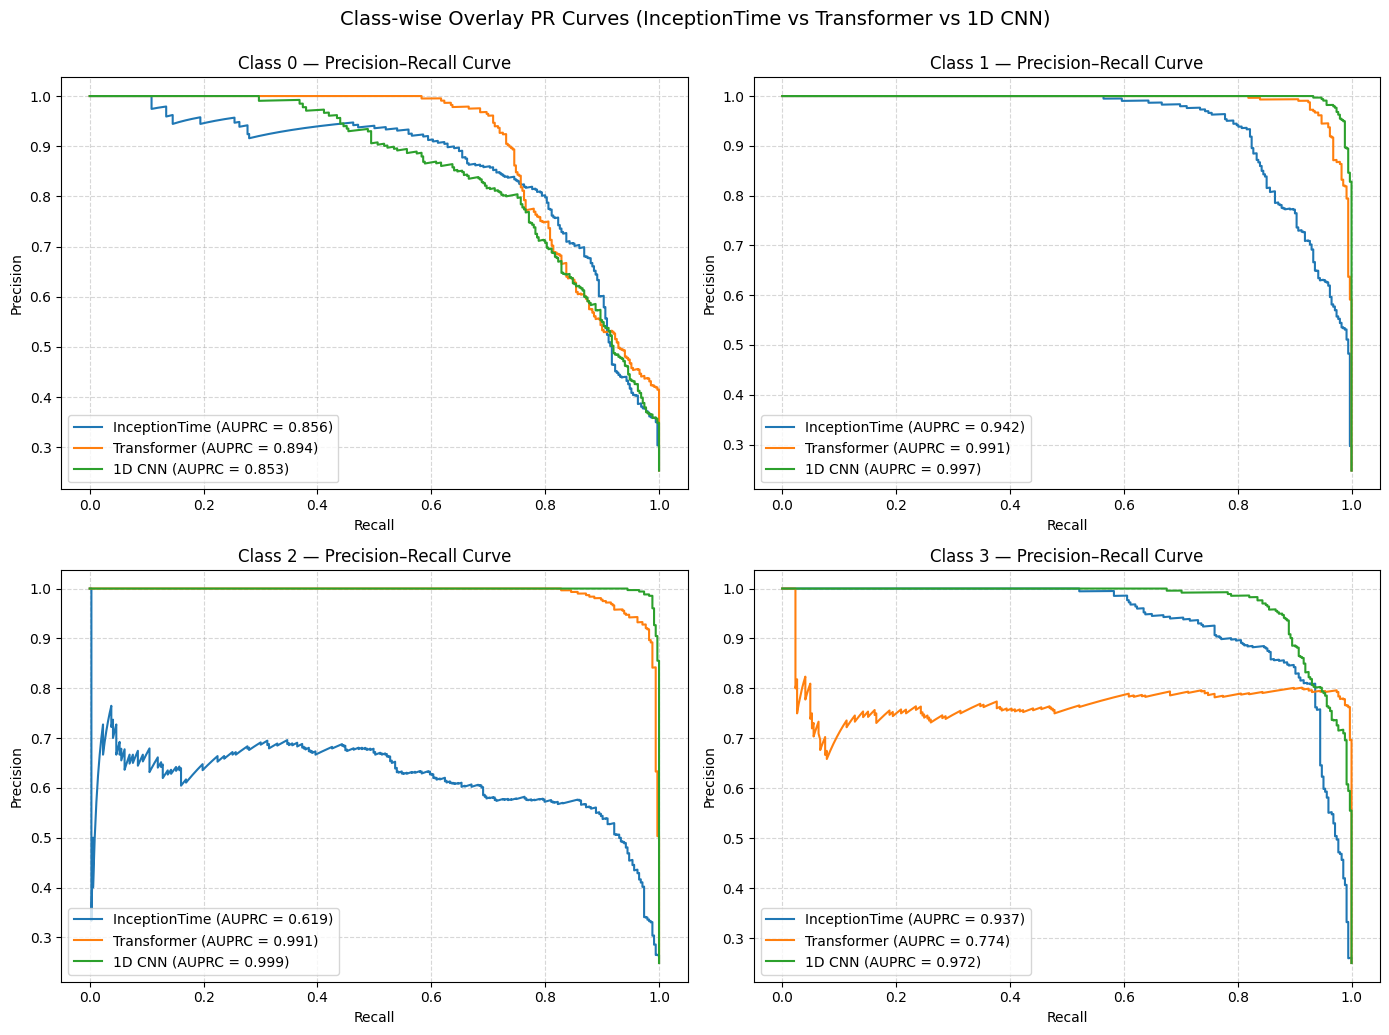

In [ ]:
# Loading data
y_true = np.load("y_true_ecgtorso.npy")
y_prob_incep = np.load("y_prob_ecgT_incep.npy")
y_prob_trans = np.load("y_prob_ecgT_trans.npy")
y_prob_cnn   = np.load("y_prob_ecgtorso_cnn.npy")

class_labels = np.unique(y_true)
n_classes = len(class_labels)

# Creating a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i in range(n_classes):
    ax = axes[i]

    # Ground truth for class i
    y_true_bin = (y_true == i).astype(int)

    # Getting model scores for class i
    scores = {
        "InceptionTime": y_prob_incep[:, i],
        "Transformer": y_prob_trans[:, i],
        "1D CNN": y_prob_cnn[:, i]
    }

    for model_name, y_scores in scores.items():
        precision, recall, _ = precision_recall_curve(y_true_bin, y_scores)
        ap = average_precision_score(y_true_bin, y_scores)
        ax.plot(recall, precision, label=f"{model_name} (AUPRC = {ap:.3f})")

    ax.set_title(f"Class {i} — Precision–Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc="lower left")

plt.tight_layout()
plt.suptitle("Class-wise Overlay PR Curves (InceptionTime vs Transformer vs 1D CNN)", fontsize=14, y=1.03)
plt.show()
